# **PROJET ALGORITHME KGB - Supervision des Systèmes**

https://www.stratosphereips.org/datasets-ctu13

https://www.sciencedirect.com/science/article/abs/pii/S0167404814000923

Fait par :       

- Dan Achille
- Alexandre Cuzou
- Arthur Desgorges
- Damien Charconnet

Le :  27/03/2025

## **Import Dataset**

In [1]:
!wget https://mcfp.felk.cvut.cz/publicDatasets/CTU-13-Dataset/CTU-13-Dataset.tar.bz2
!tar -xvjf CTU-13-Dataset.tar.bz2

--2025-05-07 09:47:05--  https://mcfp.felk.cvut.cz/publicDatasets/CTU-13-Dataset/CTU-13-Dataset.tar.bz2
Resolving mcfp.felk.cvut.cz (mcfp.felk.cvut.cz)... 147.32.82.194
Connecting to mcfp.felk.cvut.cz (mcfp.felk.cvut.cz)|147.32.82.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1997547391 (1.9G) [application/x-bzip2]
Saving to: ‘CTU-13-Dataset.tar.bz2’

CTU-13-Dataset.tar. 100%[===================>]   1.86G  32.7MB/s    in 60s     

2025-05-07 09:48:05 (31.9 MB/s) - ‘CTU-13-Dataset.tar.bz2’ saved [1997547391/1997547391]

CTU-13-Dataset/
CTU-13-Dataset/4/
CTU-13-Dataset/4/botnet-capture-20110815-rbot-dos.pcap
CTU-13-Dataset/4/capture20110815.binetflow
CTU-13-Dataset/4/README
CTU-13-Dataset/4/rbot.exe
CTU-13-Dataset/1/
CTU-13-Dataset/1/Neris.exe
CTU-13-Dataset/1/README.html
CTU-13-Dataset/1/capture20110810.binetflow
CTU-13-Dataset/1/botnet-capture-20110810-neris.pcap
CTU-13-Dataset/12/
CTU-13-Dataset/12/botnet-capture-20110819-bot.pcap
CTU-13-Dataset/12/capt

## **Import Librairies**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import os
import sys
import csv
import time
import joblib
import re
from datetime import datetime
from joblib import Parallel, delayed  # Utilisation de joblib pour le parallélisme
from tqdm import tqdm  # Utilisation de tqdm pour la barre de progression

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, confusion_matrix, fbeta_score, recall_score
from sklearn.decomposition import PCA

## **Conversion from Binetflow to CSV**

In [3]:


def binetflow_to_csv_optimized(input_path, output_path):
    """
    Convertit un fichier .binetflow en CSV de manière optimisée pour les fichiers volumineux.

    :param input_path: Chemin vers le fichier .binetflow d'entrée.
    :param output_path: Chemin vers le fichier .csv de sortie.
    :return: True si la conversion a réussi, False sinon.
    """
    start_time = time.time()

    # Vérifier l'existence du fichier d'entrée
    if not os.path.exists(input_path):
        print(f"ERREUR: Le fichier d'entrée '{input_path}' n'existe pas.", file=sys.stderr)
        return False

    file_size_mb = os.path.getsize(input_path) / (1024 * 1024)
    print(f"Traitement du fichier: {input_path}")
    print(f"Taille: {file_size_mb:.2f} MB")

    try:
        # Déterminer l'encodage et examiner le format
        encoding = 'utf-8'  # Par défaut
        expected_fields = ["StartTime", "Dur", "Proto", "SrcAddr", "Sport", "Dir",
                           "DstAddr", "Dport", "State", "sTos", "dTos", "TotPkts",
                           "TotBytes", "SrcBytes", "Label"]

        # Ouvrir le fichier d'entrée et essayer de lire les premières lignes
        with open(input_path, 'r', encoding=encoding, errors='replace') as f:
            try:
                # Lire les premières lignes pour déterminer le format
                first_lines = []
                for _ in range(5):
                    line = f.readline().strip()
                    if line:
                        first_lines.append(line)
            except UnicodeDecodeError:
                print("Problème d'encodage détecté, tentative avec latin-1...")
                encoding = 'latin-1'

        # Réessayer avec le nouvel encodage si nécessaire
        if encoding != 'utf-8':
            with open(input_path, 'r', encoding=encoding, errors='replace') as f:
                first_lines = []
                for _ in range(5):
                    line = f.readline().strip()
                    if line:
                        first_lines.append(line)

        # Afficher l'aperçu
        print("\nAperçu des données:")
        for i, line in enumerate(first_lines):
            print(f"Ligne {i+1}: {line}")

        # Déterminer si le fichier a un en-tête et son format
        has_header = False
        potential_header = first_lines[0].split(',') if first_lines else []

        # Vérifier si la première ligne ressemble à un en-tête
        if "StartTime" in first_lines[0]:
            has_header = True
            print("\nEn-tête détecté dans le fichier.")

            # Vérifier la correspondance avec les champs attendus
            missing_fields = [field for field in expected_fields if field not in potential_header]
            if missing_fields:
                print(f"ATTENTION: Champs manquants dans l'en-tête: {missing_fields}")
        else:
            print("Aucun en-tête détecté, un en-tête standard sera utilisé.")

        # Préparer le processus de conversion
        buffer_size = 8192  # Taille du buffer pour les lectures/écritures
        chunk_size = 100000  # Nombre de lignes par lot de traitement

        # Commencer la conversion
        print(f"\nDébut de la conversion vers {output_path}...")

        with open(input_path, 'r', encoding=encoding, errors='replace', buffering=buffer_size) as infile, \
             open(output_path, 'w', newline='', buffering=buffer_size) as outfile:

            csv_writer = csv.writer(outfile)

            # Écrire l'en-tête
            if has_header:
                # Utiliser l'en-tête du fichier
                header = first_lines[0].split(',')
                csv_writer.writerow(header)
                next(infile)  # Ignorer la première ligne qui est l'en-tête
            else:
                # Utiliser un en-tête par défaut
                csv_writer.writerow(expected_fields)

            # Traiter le reste du fichier par lots
            line_count = 0
            batch = []

            print("Progression du traitement:")
            start_process_time = time.time()

            for line in infile:
                line = line.strip()
                if not line:
                    continue

                # Ajouter la ligne au lot courant
                batch.append(line.split(','))
                line_count += 1

                # Traiter le lot quand il atteint la taille définie
                if len(batch) >= chunk_size:
                    csv_writer.writerows(batch)
                    batch = []

                    # Afficher la progression
                    if line_count % (chunk_size * 10) == 0:
                        elapsed = time.time() - start_process_time
                        speed = line_count / elapsed if elapsed > 0 else 0
                        print(f"  {line_count:,} lignes traitées ({speed:.2f} lignes/sec)")

            # Écrire les lignes restantes
            if batch:
                csv_writer.writerows(batch)

        # Calculer les statistiques finales
        total_time = time.time() - start_time
        output_size_mb = os.path.getsize(output_path) / (1024 * 1024)

        print("\nConversion terminée!")
        print(f"Lignes traitées: {line_count:,}")
        print(f"Temps total: {total_time:.2f} secondes")
        print(f"Vitesse moyenne: {line_count / total_time:.2f} lignes/seconde")
        print(f"Fichier de sortie: {output_path}")
        print(f"Taille du fichier de sortie: {output_size_mb:.2f} MB")

        # Vérifier le fichier de sortie
        if os.path.exists(output_path) and os.path.getsize(output_path) > 0:
            try:
                with open(output_path, 'r') as f:
                    print("\nAperçu du fichier CSV généré:")
                    for i, line in enumerate(f):
                        if i < 3:  # Afficher les 3 premières lignes
                            print(f"  {line.strip()}")
                        else:
                            break
                return True
            except Exception as e:
                print(f"Erreur lors de la vérification du fichier de sortie: {e}", file=sys.stderr)
                return False
        else:
            print("ERREUR: Le fichier de sortie est vide ou n'a pas été créé.", file=sys.stderr)
            return False

    except Exception as e:
        print(f"ERREUR lors de la conversion: {e}", file=sys.stderr)
        import traceback
        traceback.print_exc()
        return False

if __name__ == "__main__":
    # Obtenir l'heure de début pour le rapport
    start_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"=== Démarrage de la conversion à {start_datetime} ===\n")

    # Chemins des fichiers
    #input_path = "/content/CTU-13-Dataset/1/capture20110810.binetflow" # Scenario 1
    input_path = "/content/CTU-13-Dataset/10/capture20110818.binetflow" # Scenario 10
    output_path = "/content/network_packets.csv"

    # Exécuter la conversion
    success = binetflow_to_csv_optimized(input_path, output_path)

    # Rapport final
    end_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"\n=== Fin de la conversion à {end_datetime} ===")
    print(f"Statut: {'SUCCÈS' if success else 'ÉCHEC'}")

=== Démarrage de la conversion à 2025-05-07 10:02:45 ===

Traitement du fichier: /content/CTU-13-Dataset/10/capture20110818.binetflow
Taille: 170.78 MB

Aperçu des données:
Ligne 1: StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
Ligne 2: 2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,   ->,147.32.84.118,6881,S_RA,0,0,4,252,132,flow=Background-TCP-Attempt
Ligne 3: 2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,  <?>,147.32.84.229,13363,SRPA_PA,0,0,15,1318,955,flow=Background-TCP-Attempt
Ligne 4: 2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,   ->,66.235.132.232,80,SR_SA,0,0,3,212,134,flow=Background-TCP-Established
Ligne 5: 2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,   ->,147.32.84.46,10010,S_RA,0,0,4,244,124,flow=Background-TCP-Attempt

En-tête détecté dans le fichier.

Début de la conversion vers /content/network_packets.csv...
Progression du traitement:
  1,000,000 lignes trai

## **KBG Detector**

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import time
import logging
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Configuration du système de journalisation
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')
logger = logging.getLogger(__name__)

class KGBDetector:
    """
    Implémentation de l'algorithme KGB (K-means Based Genetic) pour la détection d'anomalies
    dans les flux réseau, adapté pour la détection de botnets.

    L'algorithme applique une analyse en composantes principales (PCA) sur les entropies
    des caractéristiques réseau regroupées par adresse IP source, permettant de détecter
    des comportements anormaux correspondant à des activités de botnet.

    Paramètres
    ----------
    sample_size : int
        Nombre d'échantillons à charger depuis le CSV.
    n_major_components : int
        Nombre de composantes considérées comme majeures dans le calcul du score f_major.
    threshold_PCA : float
        Fraction de variance expliquée pour déterminer le nombre de composantes à conserver.
    threshold_major : float
        Seuil (percentile) pour le score f_major sur les composantes à haute variance.
    threshold_minor : float
        Seuil (percentile) pour le score f_minor sur les composantes à faible variance.
    random_state : int
        Graine pour assurer la reproductibilité des résultats.
    verbose : bool
        Si True, affiche des informations détaillées durant le traitement.
    """
    def __init__(self,
                 sample_size=1000000,
                 n_major_components=18,
                 threshold_PCA=0.9925744596009977,
                 threshold_major=0.9997463594911226,
                 threshold_minor=0.9819175395244663,
                 random_state=42,
                 verbose=False):
        self.sample_size = sample_size
        self.n_major_components = n_major_components
        self.threshold_PCA = threshold_PCA
        self.percentil_threshold_major = threshold_major * 100
        self.percentil_threshold_minor = threshold_minor * 100
        self.verbose = verbose
        self.random_state = random_state
        np.random.seed(self.random_state)

        # Standardisation des données d'entrée
        self.scaler = StandardScaler()

        # Noms des caractéristiques dans les données Netflow (format bidirectionnel)
        self.feature_names = [
            'timestamp', 'duration', 'protocol', 'src_ip', 'src_port',
            'direction', 'dst_ip', 'dst_port', 'state', 'sTos', 'dTos',
            'total_packets', 'total_bytes', 'src_bytes'
        ]

        # Initialisation des structures de données
        self.df = None                  # DataFrame principal contenant les flux réseau
        self.X_entropy_scaled = None    # Matrice d'entropies standardisées
        self.y_true = None              # Étiquettes réelles (normal/botnet)
        self.pca_model = None           # Modèle PCA entraîné
        self.feature_importances_df = None  # Importance des caractéristiques
        self.f_major = None             # Scores d'anomalie sur composantes majeures
        self.f_minor = None             # Scores d'anomalie sur composantes mineures
        self.anomalies_df = None        # DataFrame des anomalies détectées
        self.entropy_df = None          # DataFrame des entropies calculées

        # Création d'un dossier de sortie unique pour les résultats
        self.run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.output_dir = os.path.join("kgb_results", self.run_id)
        os.makedirs(self.output_dir, exist_ok=True)
        logger.info(f"Modèle KGB initialisé => output_dir = {self.output_dir}")

    @staticmethod
    def calculate_shannon_entropy(series):
        """
        Calcule l'entropie de Shannon pour une série de valeurs.

        L'entropie de Shannon mesure le niveau d'incertitude ou de "surprise" dans une distribution.
        Une entropie élevée indique une distribution plus uniforme (plus d'incertitude),
        tandis qu'une entropie faible indique une distribution concentrée sur quelques valeurs.

        Dans le contexte de la détection d'anomalies réseau, l'entropie permet de caractériser
        la variabilité des adresses, ports, et autres caractéristiques des flux.

        Formule: H(X) = -∑ p_k * log(p_k)
        où p_k est la probabilité de chaque valeur distincte dans la série.

        Paramètres
        ----------
        series : pandas.Series
            Série de données pour laquelle calculer l'entropie

        Retourne
        --------
        float
            Valeur de l'entropie de Shannon calculée
        """
        # Calcul des fréquences relatives de chaque valeur unique
        counts = series.value_counts()
        probabilities = counts / counts.sum()

        # On ajoute une très petite constante pour éviter log(0)
        entropy = -np.sum(probabilities * np.log(probabilities + 1e-10))
        return entropy

    def load_and_label_network_flows(self, csv_file_path):
        """
        Charge et étiquette les données de flux réseau à partir d'un fichier CSV prétraité.

        Cette fonction traite directement le fichier CSV prétraité:
        1. Chargement du fichier CSV contenant les données de flux réseau
        2. Attribution des noms de colonnes selon le schéma du dataset
        3. Conversion des timestamps en format numérique pour faciliter l'analyse
        4. Génération des étiquettes de classification (normal vs botnet) basées sur l'analyse
           des chaînes dans la colonne 'flow'

        Paramètres
        ----------
        csv_file_path : str
            Chemin vers le fichier CSV prétraité contenant les données réseau

        Retourne
        --------
        pandas.DataFrame
            Le DataFrame contenant les flux réseau avec étiquettes

        Lève
        ----
        FileNotFoundError
            Si le fichier CSV n'est pas trouvé
        ValueError
            Si le fichier ne contient pas suffisamment de colonnes
        """
        if not os.path.exists(csv_file_path):
            logger.error("Fichier CSV non trouvé: %s", csv_file_path)
            raise FileNotFoundError(f"Fichier CSV non trouvé: {csv_file_path}")

        try:
            # Lecture du fichier CSV prétraité
            self.df = pd.read_csv(csv_file_path, header=0, engine='python', nrows=self.sample_size)
            # Attribution des noms de colonnes
            columns = self.feature_names.copy()
            columns.append('flow')
            self.df.columns = columns
            logger.info(f"Fichier CSV chargé (premiers {self.sample_size} échantillons). Forme: {self.df.shape}")
        except Exception as e:
            logger.error("Erreur lors de la lecture du fichier CSV: %s", e)
            raise

        if self.df.shape[1] < 15:
            raise ValueError("Le fichier CSV doit contenir au moins 15 colonnes au format attendu.")

        # Conversion de la colonne 'timestamp' en valeurs numériques (timestamp Unix en secondes)
        # pour faciliter les calculs d'agrégation temporelle
        try:
            self.df['timestamp'] = pd.to_datetime(self.df['timestamp'], errors='coerce')
            # Remplacement des valeurs NaT par une date par défaut
            self.df['timestamp'] = self.df['timestamp'].fillna(pd.Timestamp('1970-01-01'))
            # Conversion en int64 (nombre de nanosecondes) puis passage en secondes
            self.df['timestamp'] = self.df['timestamp'].astype('int64') // 10**9
        except Exception as e:
            logger.error("Erreur lors de la conversion de 'timestamp': %s", e)
            raise

        # Génération de l'étiquette (Label) à partir de la colonne 'flow'
        # On recherche des mots-clés associés aux activités de botnet
        suspicious_keywords = ['from-botnet', 'botnet', 'attack', 'ddos', 'malicious',
                              'trojan', 'worm', 'exploit', 'phishing', 'backdoor']
        pattern = re.compile(r'(' + '|'.join(suspicious_keywords) + r')', re.IGNORECASE)
        self.df['Label'] = self.df['flow'].astype(str).apply(lambda x: 1 if pattern.search(x) else 0)

        # Calcul des statistiques de base sur les étiquettes
        positive_count = self.df['Label'].sum()
        total_samples = self.df.shape[0]
        logger.info(f"Prétraitement => {self.df.shape[1]} features, {total_samples} échantillons, positifs: {positive_count} ({(positive_count/total_samples)*100:.2f}%).")
        print(f"Prétraitement => {self.df.shape[1]} features, {total_samples} échantillons, positifs: {positive_count} ({(positive_count/total_samples)*100:.2f}%).")
        self.y_true = self.df['Label'].values

        # Note: Nous ne standardisons pas ici les features d'origine car elles contiennent
        # des colonnes catégorielles (ex: protocol, src_ip, etc.). La standardisation sera appliquée
        # plus tard sur les entropies calculées par groupe.
        print("Données prêtes pour le calcul d'entropie.")
        return self.df

    def perform_kgb_detection(self):
        """
        Exécute l'algorithme KGB pour la détection d'anomalies dans les flux réseau.

        Cette méthode implémente les étapes principales de l'algorithme KGB:
        1. Regroupement des flux par adresse IP source (chaque source est analysée individuellement)
        2. Calcul de l'entropie pour chaque caractéristique et chaque groupe
        3. Standardisation des entropies calculées
        4. Application d'une PCA pour extraire les composantes principales
        5. Classification en deux modes:
           - KGBf: utilise les composantes à haute variance (f_major)
           - KGBfog: utilise les composantes à faible variance (f_minor)
        6. Détection des anomalies basée sur des seuils de percentile

        Retourne
        --------
        pandas.DataFrame
            Le DataFrame original avec une colonne 'predictions' contenant
            les prédictions d'anomalies (1=anomalie, 0=normal)
        """
        # 1. Regroupement par adresse IP source
        grouped = self.df.groupby('src_ip')
        entropy_list = []
        ids = []

        # 2. Calcul des entropies pour chaque groupe (adresse IP source)
        for group_id, group in tqdm(grouped, desc="Calcul des entropies par IP source"):
            if group.empty:
                continue

            # Pour chaque caractéristique, calculer l'entropie de sa distribution dans le groupe
            entropies = group[self.feature_names].apply(self.calculate_shannon_entropy)
            entropy_list.append(entropies.tolist())
            ids.append(group_id)

        # Construction du DataFrame d'entropies
        entropy_df = pd.DataFrame(entropy_list, columns=[f'H_{feat}' for feat in self.feature_names])
        entropy_df.insert(0, 'src_ip', ids)
        self.entropy_df = entropy_df
        print("Exemple d'IP source:", ids[:5])
        print("Entropies calculées:\n", entropy_df.head())

        # 3. Standardisation des entropies (moyenne=0, écart-type=1)
        entropy_values = entropy_df[[f'H_{feat}' for feat in self.feature_names]].values
        self.X_entropy_scaled = self.scaler.fit_transform(entropy_values)
        print("Données d'entropie standardisées. Forme :", self.X_entropy_scaled.shape)

        # 4. Application de la PCA pour réduire la dimensionnalité
        self.pca_model = PCA(n_components=self.threshold_PCA, whiten=False, random_state=self.random_state)
        principal_components = self.pca_model.fit_transform(self.X_entropy_scaled)
        eigenvalues = self.pca_model.explained_variance_
        n_components = principal_components.shape[1]
        print(f"Nombre de composantes retenues: {n_components}")
        print(f"Variance expliquée cumulée: {np.sum(self.pca_model.explained_variance_ratio_)*100:.2f}%")

        # 5. Calcul des scores d'anomalie selon deux approches de l'algorithme KGB
        # KGBf: utilise les composantes à haute variance (f_major)
        f_major = np.sum((principal_components[:, :self.n_major_components]**2) /
                         (eigenvalues[:self.n_major_components]**2), axis=1)

        # KGBfog: utilise les composantes à faible variance (f_minor)
        if n_components > self.n_major_components:
            f_minor = np.sum((principal_components[:, self.n_major_components:]**2) /
                            (eigenvalues[self.n_major_components:]**2), axis=1)
        else:
            f_minor = np.zeros_like(f_major)

        # Sauvegarde des scores pour affichage ultérieur
        self.f_major = f_major
        self.f_minor = f_minor

        # 6. Détermination des seuils et détection des anomalies
        threshold_major = np.percentile(f_major, self.percentil_threshold_major)
        threshold_minor = np.percentile(f_minor, self.percentil_threshold_minor)
        print(f"Seuil f_major (p{self.percentil_threshold_major}): {threshold_major}")
        print(f"Seuil f_minor (p{self.percentil_threshold_minor}): {threshold_minor}")

        # Une adresse IP est considérée comme anomalie si son score dépasse l'un des seuils
        anomaly_mask = (f_major > threshold_major) | (f_minor > threshold_minor)
        anomaly_indices = np.where(anomaly_mask)[0]

        # Construction du DataFrame des anomalies détectées
        anomalies_df = entropy_df.loc[anomaly_indices].copy()
        anomalies_df['f_major'] = f_major[anomaly_indices]
        anomalies_df['f_minor'] = f_minor[anomaly_indices]
        anomalies_df['threshold_major'] = threshold_major
        anomalies_df['threshold_minor'] = threshold_minor
        self.anomalies_df = anomalies_df
        print("Premières anomalies détectées:\n", anomalies_df.head())

        # Sauvegarde des résultats
        anomalies_csv_path = os.path.join(self.output_dir, 'detected_anomalies.csv')
        anomalies_df.to_csv(anomalies_csv_path, index=False)
        print(f"{len(anomalies_df)} adresses IP source anormales détectées. Résultats sauvegardés dans '{anomalies_csv_path}'.")

        # Ajout des prédictions dans le DataFrame principal
        # Un flux est prédit comme anomalie si son adresse IP source est dans la liste des anomalies
        self.df['predictions'] = self.df['src_ip'].isin(anomalies_df['src_ip']).astype(int)
        return self.df

    def evaluate_detection_performance(self, predictions_col="predictions"):
        """
        Évalue les performances de détection en calculant la matrice de confusion et les métriques associées.

        Cette méthode compare les prédictions du modèle avec les étiquettes réelles
        pour calculer:
        - Vrai Positifs (TP): flux correctement identifiés comme botnet
        - Vrai Négatifs (TN): flux correctement identifiés comme normaux
        - Faux Positifs (FP): flux normaux incorrectement classés comme botnet
        - Faux Négatifs (FN): flux botnet non détectés

        Et les métriques de performance dérivées:
        - Précision: TP/(TP+FP) - Proportion des détections correctes parmi les alertes
        - Rappel: TP/(TP+FN) - Proportion des botnets correctement détectés
        - Score F1: moyenne harmonique de la précision et du rappel

        Paramètres
        ----------
        predictions_col : str, default="predictions"
            Nom de la colonne contenant les prédictions dans le DataFrame

        Retourne
        --------
        tuple
            Un tuple (TN, FP, FN, TP) contenant les éléments de la matrice de confusion
        """
        y_true = self.df['Label'].values
        y_pred = self.df[predictions_col].values

        # Vérification que les deux classes sont présentes dans les étiquettes
        if len(np.unique(y_true)) == 2:
            cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
            tn, fp, fn, tp = cm.ravel()

            # Calcul des métriques de performance
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            logger.info(f"Matrice de confusion => TN={tn}, FP={fp}, FN={fn}, TP={tp}")
            logger.info(f"Précision: {precision:.4f} - Proportion de vrais positifs parmi les détections")
            logger.info(f"Rappel: {recall:.4f} - Proportion des anomalies correctement détectées")
            logger.info(f"Score F1: {f1:.4f} - Moyenne harmonique précision/rappel")
            return tn, fp, fn, tp
        else:
            logger.info("Classe positive absente dans les étiquettes réelles.")
            return (0, 0, 0, 0)

    def rank_feature_importance(self, n_components=None, method="weighted"):
        """
        Calcule et classe l'importance relative de chaque caractéristique réseau.

        Cette méthode utilise les vecteurs propres de la PCA pour déterminer quelles
        caractéristiques contribuent le plus à la variance des données et donc
        à la discrimination entre comportements normaux et anormaux.

        Deux méthodes sont disponibles:
        - "weighted": pondère l'importance par la variance expliquée (privilégie les composantes majeures)
        - "absolute": considère uniquement les coefficients absolus (sans pondération)

        Paramètres
        ----------
        n_components : int ou None
            Nombre de composantes à considérer. Si None, toutes les composantes sont utilisées.
        method : str, "weighted" ou "absolute"
            Méthode de calcul de l'importance

        Retourne
        --------
        pandas.DataFrame
            DataFrame contenant les caractéristiques et leur importance, trié par
            ordre décroissant d'importance

        Lève
        ----
        ValueError
            Si le modèle PCA n'est pas encore entraîné
        """
        if not hasattr(self.pca_model, 'components_'):
            raise ValueError("Le modèle PCA n'est pas entraîné. Exécutez d'abord perform_kgb_detection().")

        if len(self.feature_names) != self.pca_model.components_.shape[1]:
            raise ValueError("Dimensions incompatibles entre feature_names et le modèle PCA.")

        # Récupération des composantes et de leur variance expliquée
        components = self.pca_model.components_
        explained_variance_ratio = self.pca_model.explained_variance_ratio_

        # Limitation du nombre de composantes à utiliser
        if n_components is None or n_components > components.shape[0]:
            n_components = components.shape[0]

        # Calcul de l'importance pour chaque caractéristique
        n_features = len(self.feature_names)
        importances = np.zeros(n_features, dtype=float)

        for j in range(n_components):
            coeffs = components[j, :]
            # Pondération par la variance expliquée si méthode weighted
            weight = explained_variance_ratio[j] if method == "weighted" else 1.0
            importances += np.abs(coeffs) * weight

        # Construction du DataFrame des importances
        feature_importances = {feat: importances[i] for i, feat in enumerate(self.feature_names)}
        feature_importances_df = pd.DataFrame.from_dict(feature_importances, orient='index', columns=['importance'])
        feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False).reset_index().rename(columns={'index': 'feature'})

        self.feature_importances_df = feature_importances_df
        return feature_importances_df

    def create_analysis_visualizations(self, percentile_cut=99.0):
        """
        Génère un ensemble de visualisations pour analyser les résultats de la détection.

        Cette méthode crée sept graphiques différents pour analyser en profondeur
        les performances et caractéristiques du modèle KGB:

        1) Matrice de confusion - évaluation des performances de classification
        2) Top 10 features par importance - identification des caractéristiques discriminantes
        3) Distribution des scores d'anomalie - visualisation de la séparation des classes
        4) Scatter plot PCA - projection des données dans l'espace réduit
        5) Courbe ROC - évaluation globale de la performance de classification
        6) Corrélation des entropies - visualisation des relations entre caractéristiques
        7) Variance expliquée par composante - analyse de la contribution des composantes PCA

        Tous les graphiques sont sauvegardés dans le répertoire de sortie pour analyse ultérieure.

        Paramètres
        ----------
        percentile_cut : float, default=99.0
            Percentile utilisé pour tronquer les visualisations et éliminer les valeurs extrêmes
        """
        sns.set_style("whitegrid")

        # 1) Matrice de confusion pour évaluer les performances globales
        tn, fp, fn, tp = self.evaluate_detection_performance()
        cm = np.array([[tn, fp], [fn, tp]])
        plt.figure(figsize=(5,4))
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                         xticklabels=["Prédit: Normal", "Prédit: Anomalie"],
                         yticklabels=["Réel: Normal", "Réel: Anomalie"])
        plt.title("Matrice de confusion")
        plt.xlabel("Prédictions")
        plt.ylabel("Valeurs réelles")
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "1_confusion_matrix.png"), dpi=100)
        plt.show()
        plt.close()

        # 2) Top 10 features par importance pour identifier les caractéristiques clés
        importance_df = self.rank_feature_importance()
        top_features = importance_df.head(10)
        plt.figure(figsize=(6,5))
        sns.barplot(x="importance", y="feature", data=top_features, palette="rocket", edgecolor='black')
        plt.xlabel("Importance")
        plt.title("Top 10 caractéristiques par importance")
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "2_top_features.png"), dpi=100)
        plt.show()
        plt.close()

        # 3) Distribution des scores d'anomalie pour visualiser la séparation des classes
        plt.figure(figsize=(6,5))
        sns.histplot(self.f_major, bins=30, color="skyblue", edgecolor='black', label='f_major', kde=True)
        sns.histplot(self.f_minor, bins=30, color="salmon", edgecolor='black', label='f_minor', kde=True)
        plt.axvline(np.percentile(self.f_major, self.percentil_threshold_major), color='blue', linestyle='--', label='Seuil f_major')
        plt.axvline(np.percentile(self.f_minor, self.percentil_threshold_minor), color='red', linestyle='--', label='Seuil f_minor')
        plt.title("Distribution des scores d'anomalie")
        plt.xlabel("Score")
        plt.ylabel("Fréquence")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "3_anomaly_scores_distribution.png"), dpi=100)
        plt.show()
        plt.close()

        # 4) Scatter Plot PCA pour visualiser la séparation des données dans l'espace réduit
        # Création d'un mapping entre les src_ip et les prédictions/étiquettes
        ip_to_pred = {}
        ip_to_true = {}

        # Vérification des données requises
        if self.anomalies_df is None or self.entropy_df is None:
            logger.warning("Impossible de générer le scatter plot PCA: anomalies_df ou entropy_df manquant")
            return

        # Création du mapping des prédictions (1 si l'IP est dans les anomalies détectées)
        for ip in self.entropy_df['src_ip']:
            ip_to_pred[ip] = 1 if ip in self.anomalies_df['src_ip'].values else 0

        # Création du mapping des étiquettes réelles
        grouped = self.df.groupby('src_ip')
        for ip, group in grouped:
            # Une IP est considérée comme anomalie réelle si au moins un de ses flux est marqué comme tel
            ip_to_true[ip] = 1 if 1 in group['Label'].values else 0

        # Création des arrays pour les étiquettes au niveau des groupes (src_ip)
        src_ips = self.entropy_df['src_ip'].values
        y_true_group = np.array([ip_to_true.get(ip, 0) for ip in src_ips])
        y_pred_group = np.array([ip_to_pred.get(ip, 0) for ip in src_ips])

        # Catégorisation: TN=0, FP=1, FN=2, TP=3
        cat_array = np.zeros(len(src_ips), dtype=int)
        cat_array[(y_true_group == 0) & (y_pred_group == 0)] = 0  # TN
        cat_array[(y_true_group == 0) & (y_pred_group == 1)] = 1  # FP
        cat_array[(y_true_group == 1) & (y_pred_group == 0)] = 2  # FN
        cat_array[(y_true_group == 1) & (y_pred_group == 1)] = 3  # TP

        # Préparation des données pour la visualisation PCA à 2 dimensions
        if hasattr(self, 'X_entropy_scaled') and self.X_entropy_scaled is not None:
            X_scaled_trunc = self.X_entropy_scaled
            cat_trunc = cat_array

            # Limite le nombre de points pour la lisibilité
            max_points = 8000
            if len(X_scaled_trunc) > max_points:
                idx_sample = np.random.choice(len(X_scaled_trunc), size=max_points, replace=False)
                X_scaled_trunc = X_scaled_trunc[idx_sample]
                cat_trunc = cat_array[idx_sample]

            # Création d'une PCA à 2 dimensions pour la visualisation
            pca_2d = PCA(n_components=2, random_state=self.random_state)
            X_pca = pca_2d.fit_transform(X_scaled_trunc)

            # Configuration du graphique
            palette = {0: "gray", 1: "red", 2: "orange", 3: "green"}
            labels_cat = {0: "TN", 1: "FP", 2: "FN", 3: "TP"}
            plt.figure(figsize=(7,6))

            # Affichage des points par catégorie
            for c in [0, 1, 2, 3]:
                submask = (cat_trunc == c)
                if np.any(submask):  # Vérifier que le masque contient au moins un élément True
                    plt.scatter(X_pca[submask, 0], X_pca[submask, 1],
                                c=palette[c], label=labels_cat[c], alpha=0.6, s=30)

            plt.title("PCA - Classification des adresses IP sources")
            plt.xlabel("Composante principale 1")
            plt.ylabel("Composante principale 2")
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_dir, "4_pca_scatter.png"), dpi=100)
            plt.show()
            plt.close()

        # 5) Courbe ROC pour évaluer la performance globale de détection
        try:
            from sklearn.metrics import roc_curve, auc
            # Calcul de la courbe ROC en utilisant les scores d'anomalie comme probabilités
            # Score composite = f_major + f_minor
            score_composite = self.f_major + self.f_minor

            # Préparation des étiquettes réelles au niveau des adresses IP
            true_labels = y_true_group

            # Calcul de la courbe ROC
            fpr, tpr, thresholds = roc_curve(true_labels, score_composite)
            roc_auc = auc(fpr, tpr)

            # Création du graphique ROC
            plt.figure(figsize=(6, 5))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
            plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('Taux de faux positifs')
            plt.ylabel('Taux de vrais positifs')
            plt.title('Courbe ROC')
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_dir, "5_roc_curve.png"), dpi=100)
            plt.show()
            plt.close()
        except Exception as e:
            logger.warning(f"Impossible de générer la courbe ROC: {e}")

        # 6) Matrice de corrélation des entropies pour comprendre les relations entre caractéristiques
        if self.X_entropy_scaled is not None:
            # Récupérer les données d'entropie avant standardisation
            entropy_features = [f'H_{feat}' for feat in self.feature_names]
            entropy_df = pd.DataFrame(
                self.scaler.inverse_transform(self.X_entropy_scaled),
                columns=entropy_features
            )

            # Sélectionner les 10 caractéristiques les plus importantes
            top_entropy_features = ['H_' + feat for feat in importance_df.head(10)['feature']]
            entropy_df_top = entropy_df[top_entropy_features]

            # Calculer et afficher la matrice de corrélation
            plt.figure(figsize=(9, 8))
            corr_matrix = entropy_df_top.corr()
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
            sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f',
                        linewidths=0.5, vmin=-1, vmax=1)
            plt.title("Corrélation entre les entropies des caractéristiques principales")
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_dir, "6_correlation_matrix.png"), dpi=100)
            plt.show()
            plt.close()

        # 7) Variance expliquée par composante PCA pour comprendre la distribution de l'information
        if hasattr(self.pca_model, 'explained_variance_ratio_'):
            plt.figure(figsize=(8, 5))

            # Variance expliquée par composante individuelle
            plt.subplot(1, 2, 1)
            variance_ratio = self.pca_model.explained_variance_ratio_
            plt.bar(range(1, len(variance_ratio) + 1), variance_ratio, alpha=0.7,
                color='steelblue', edgecolor='black')
            plt.xlabel('Composante principale')
            plt.ylabel('Variance expliquée')
            plt.title('Variance expliquée par composante')
            plt.xticks(range(1, len(variance_ratio) + 1, 2))

            # Variance expliquée cumulée
            plt.subplot(1, 2, 2)
            cumulative_variance = np.cumsum(variance_ratio)
            plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
                    marker='o', linestyle='-', color='darkorange')
            plt.axhline(y=0.95, color='red', linestyle='--', label='95% variance')
            plt.axhline(y=0.99, color='green', linestyle='--', label='99% variance')
            plt.xlabel('Nombre de composantes')
            plt.ylabel('Variance expliquée cumulée')
            plt.title('Variance expliquée cumulée')
            plt.legend()
            plt.xticks(range(1, len(variance_ratio) + 1, 2))

            plt.tight_layout()
            plt.savefig(os.path.join(self.output_dir, "7_pca_variance.png"), dpi=100)
            plt.show()
            plt.close()

        return




## **Runner**

In [5]:
def run_botnet_detection_pipeline(csv_file_path, sample_size=1000000):
    """
    Pipeline principal pour exécuter la détection de botnets avec l'algorithme KGB.

    Cette fonction orchestre l'ensemble du processus de détection:
    1. Initialisation du détecteur KGB avec les paramètres par défaut
    2. Chargement et étiquetage des flux réseau depuis le fichier CSV prétraité
    3. Exécution de la détection d'anomalies
    4. Évaluation des performances
    5. Analyse de l'importance des caractéristiques
    6. Génération des visualisations d'analyse

    Paramètres
    ----------
    csv_file_path : str
        Chemin vers le fichier CSV prétraité contenant les données de flux réseau
    sample_size : int, default=1000000
        Nombre d'échantillons à utiliser dans l'analyse

    Retourne
    --------
    tuple
        Un tuple (detector, df) contenant:
        - detector: L'instance du détecteur KGB après l'analyse
        - df: Le DataFrame avec les prédictions d'anomalies
    """
    t0 = time.time()
    logger.info("Initialisation du détecteur KGB...")
    print("Initialisation...")
    kgb_detector = KGBDetector(sample_size=sample_size, verbose=True)

    print("Chargement et étiquetage des flux réseau depuis le fichier CSV prétraité...")
    kgb_detector.load_and_label_network_flows(csv_file_path)
    t1 = time.time()
    print(f"Temps de chargement et prétraitement: {t1 - t0:.2f} s\n")

    logger.info("Exécution de la détection d'anomalies avec l'algorithme KGB...")
    df = kgb_detector.perform_kgb_detection()
    t2 = time.time()
    print(f"Anomalies détectées : {np.sum(df['predictions'])} sur {df.shape[0]} échantillons")
    print(f"Temps de détection: {t2 - t1:.2f} s")

    print("\nCalcul de la matrice de confusion et évaluation des performances...")
    tn, fp, fn, tp = kgb_detector.evaluate_detection_performance()
    print(f"Matrice de confusion : TN={tn}, FP={fp}, FN={fn}, TP={tp}")

    print("\nAnalyse de l'importance des caractéristiques...")
    importance_df = kgb_detector.rank_feature_importance()
    print("Caractéristiques les plus discriminantes :")
    print(importance_df.head(10))

    print("\nGénération des visualisations d'analyse...")
    kgb_detector.create_analysis_visualizations()
    t3 = time.time()
    print(f"Temps de génération des graphiques: {t3 - t2:.2f} s")

    logger.info(f"Analyse terminée en {t3 - t0:.2f} secondes. Résultats sauvegardés dans: {kgb_detector.output_dir}")
    return kgb_detector, df


## **Main**

Initialisation...
Chargement et étiquetage des flux réseau depuis le fichier CSV prétraité...
Prétraitement => 16 features, 1000000 échantillons, positifs: 74877 (7.49%).
Données prêtes pour le calcul d'entropie.
Temps de chargement et prétraitement: 20.40 s



Calcul des entropies par IP source: 100%|██████████| 116978/116978 [17:45<00:00, 109.76it/s]


Exemple d'IP source: ['0.0.0.0', '00:0b:ac:c4:e7:40', '00:0b:ac:c5:cf:00', '00:0c:29:97:a3:eb', '00:15:17:2c:e5:2d']
Entropies calculées:
               src_ip   H_timestamp    H_duration    H_protocol      H_src_ip  \
0            0.0.0.0  1.386294e+00  1.386294e+00 -1.000000e-10 -1.000000e-10   
1  00:0b:ac:c4:e7:40 -1.000000e-10 -1.000000e-10 -1.000000e-10 -1.000000e-10   
2  00:0b:ac:c5:cf:00 -1.000000e-10 -1.000000e-10 -1.000000e-10 -1.000000e-10   
3  00:0c:29:97:a3:eb  1.098612e+00 -1.000000e-10 -1.000000e-10 -1.000000e-10   
4  00:15:17:2c:e5:2d  1.386294e+00  1.386294e+00 -1.000000e-10 -1.000000e-10   

     H_src_port   H_direction      H_dst_ip    H_dst_port       H_state  \
0 -1.000000e-10 -1.000000e-10 -1.000000e-10 -1.000000e-10  5.623351e-01   
1 -1.000000e-10 -1.000000e-10 -1.000000e-10 -0.000000e+00 -1.000000e-10   
2 -1.000000e-10 -1.000000e-10 -1.000000e-10 -0.000000e+00 -1.000000e-10   
3 -0.000000e+00 -1.000000e-10 -1.000000e-10 -0.000000e+00 -1.000000e-10   
4 -0.

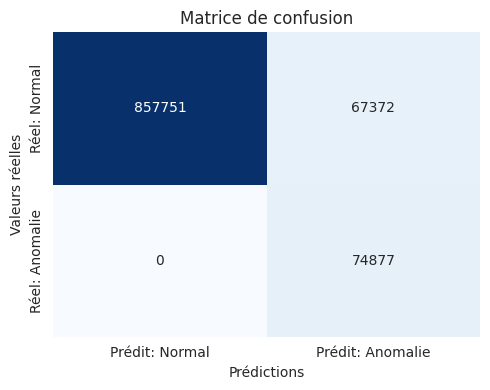

<ipython-input-4-f58eebc3ce9c>:455: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=top_features, palette="rocket", edgecolor='black')


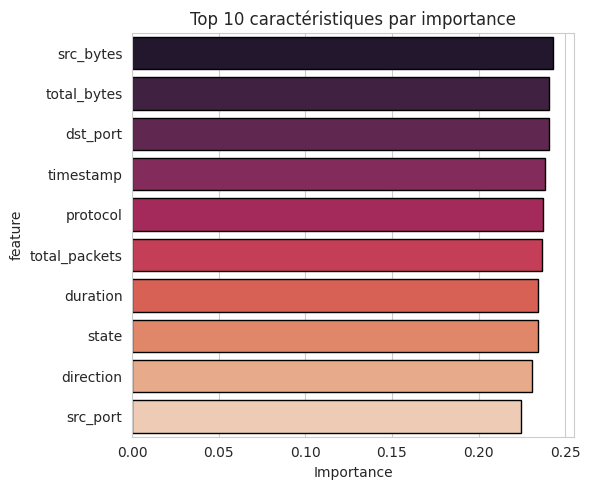

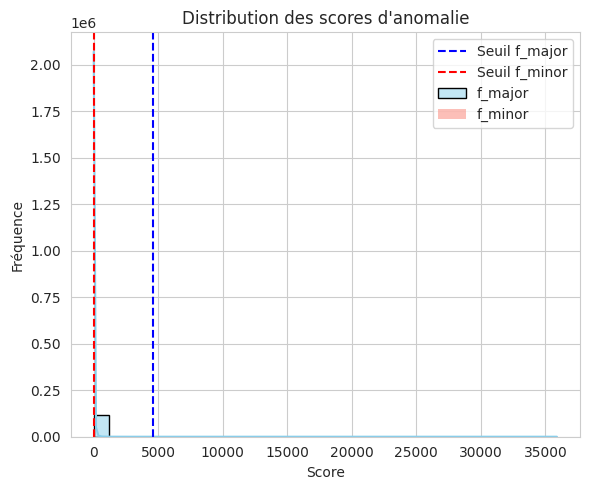

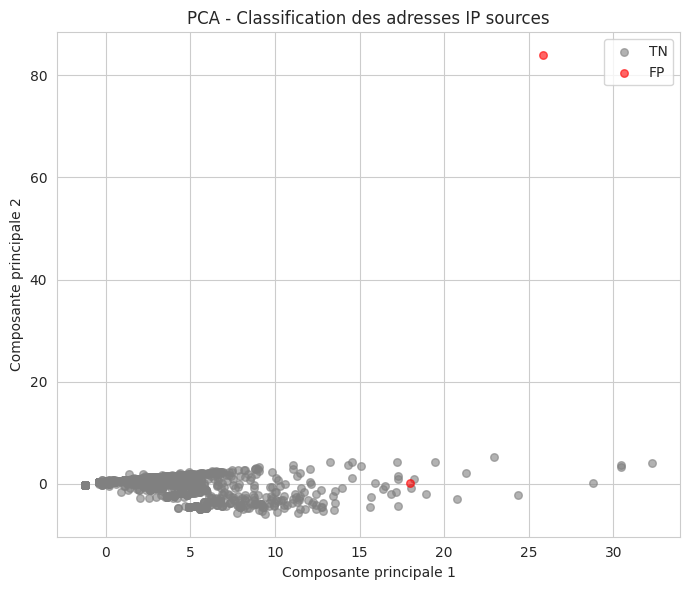

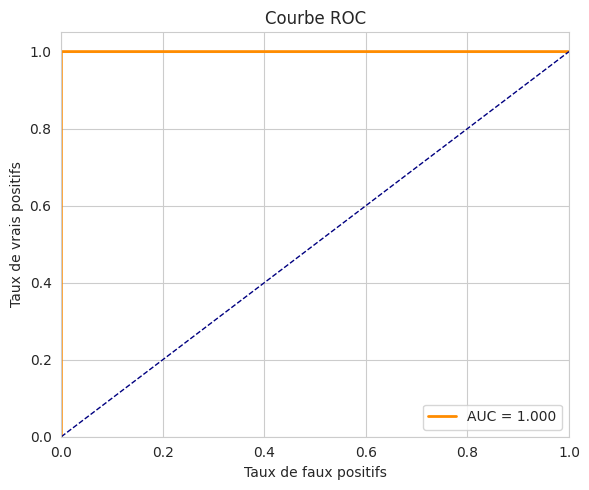

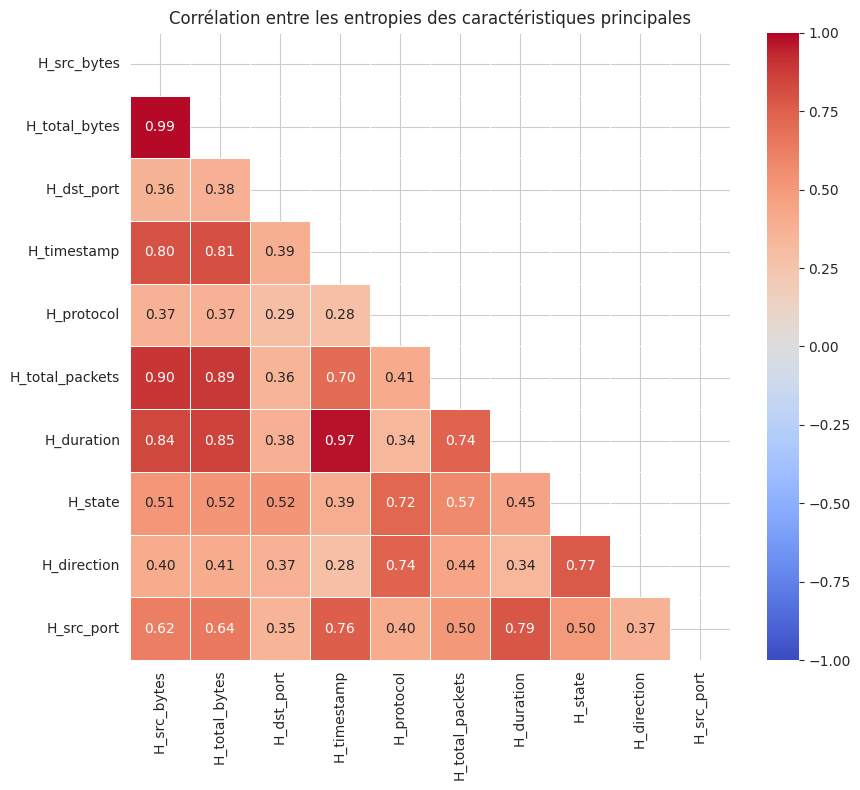

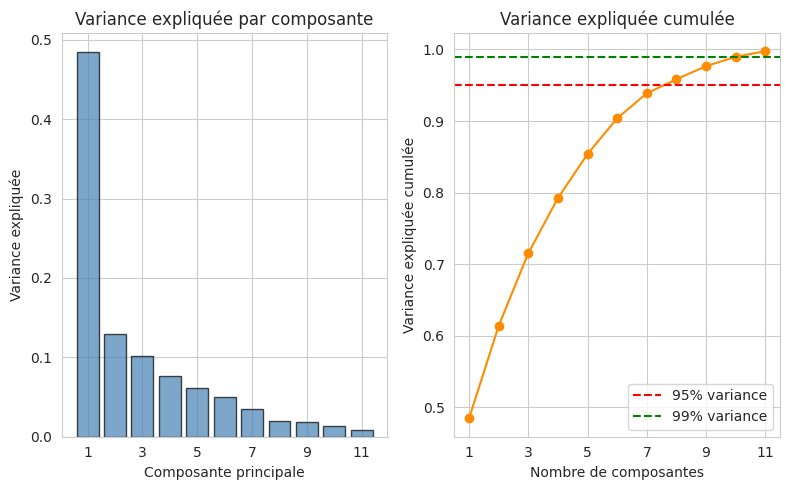

Temps de génération des graphiques: 12.14 s
Analyse complète! 142249 anomalies détectées.
Résultats sauvegardés dans: kgb_results/20250507_120900

Aperçu des anomalies détectées (10 premières lignes):
      timestamp     duration protocol         src_ip src_port direction  \
129  1313662753     0.002636      tcp  147.32.86.166    33426       <?>   
131  1313662753  3599.473633      tcp  147.32.86.166    42020       <?>   
143  1313662753  3599.985596      tcp  147.32.86.166    48761       <?>   
145  1313662753  1744.221436      tcp  147.32.84.229    13363       <?>   
155  1313662753  3520.204346      tcp  147.32.84.229    13363       <?>   
156  1313662753  3599.849609      tcp  147.32.84.229     3792       <?>   
159  1313662753  3516.261475      tcp  147.32.84.229      443       <?>   
160  1313662753  3589.104492      tcp  147.32.84.229    13363       <?>   
165  1313662753  3580.024414      tcp  147.32.84.229    13363       <?>   
174  1313662753  3073.394531      udp  147.32.84.

In [18]:
if __name__ == "__main__":
    try:
        # Chemin vers le fichier CSV prétraité
        csv_file_path = "network_packets.csv"  # Fichier CSV prétraité
        sample_size = 1000000

        # Exécution du pipeline complet de détection
        detector, df_processed = run_botnet_detection_pipeline(csv_file_path, sample_size=sample_size)

        # Affichage du résumé des résultats
        anomaly_count = np.sum(df_processed['predictions'])
        logger.info(f"Analyse finale => {anomaly_count} anomalies détectées sur {len(df_processed)} échantillons.")
        print(f"Analyse complète! {anomaly_count} anomalies détectées.")
        print(f"Résultats sauvegardés dans: {detector.output_dir}")

        print("\nAperçu des anomalies détectées (10 premières lignes):")
        anomalies_df = df_processed[df_processed['predictions'] == 1]
        print(anomalies_df.head(10))
    except Exception as e:
        logger.error(f"Erreur dans l'exécution principale: {e}")
        print(f"Erreur: {e}")

## **Data Analysis**

### Histogramme de la distribution des paquets botnet et prédits en fonction de l'indice

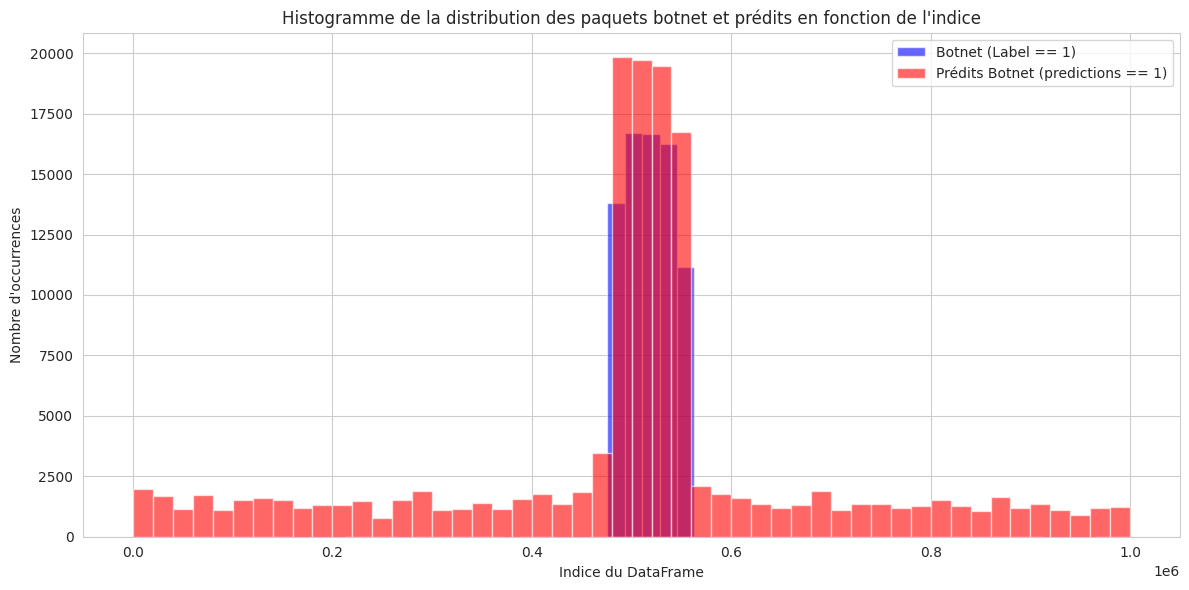

In [19]:
import matplotlib.pyplot as plt

# Extraire les indices pour lesquels le label est botnet et la prédiction est botnet
indices_botnet = df_processed.index[df_processed['Label'] == 1]
indices_pred_botnet = df_processed.index[df_processed['predictions'] == 1]


plt.figure(figsize=(12, 6))

# Histogramme pour les paquets réels (Label == 1)
plt.hist(indices_botnet, bins=50, alpha=0.6, label='Botnet (Label == 1)', color='blue')

# Histogramme pour les paquets prédits (predictions == 1)
plt.hist(indices_pred_botnet, bins=50, alpha=0.6, label='Prédits Botnet (predictions == 1)', color='red')

plt.xlabel("Indice du DataFrame")
plt.ylabel("Nombre d'occurrences")
plt.title("Histogramme de la distribution des paquets botnet et prédits en fonction de l'indice")
plt.legend()
plt.tight_layout()
plt.show()


### Nombre d'occurence en fonction des top 10 IP source et des top 10 ports source

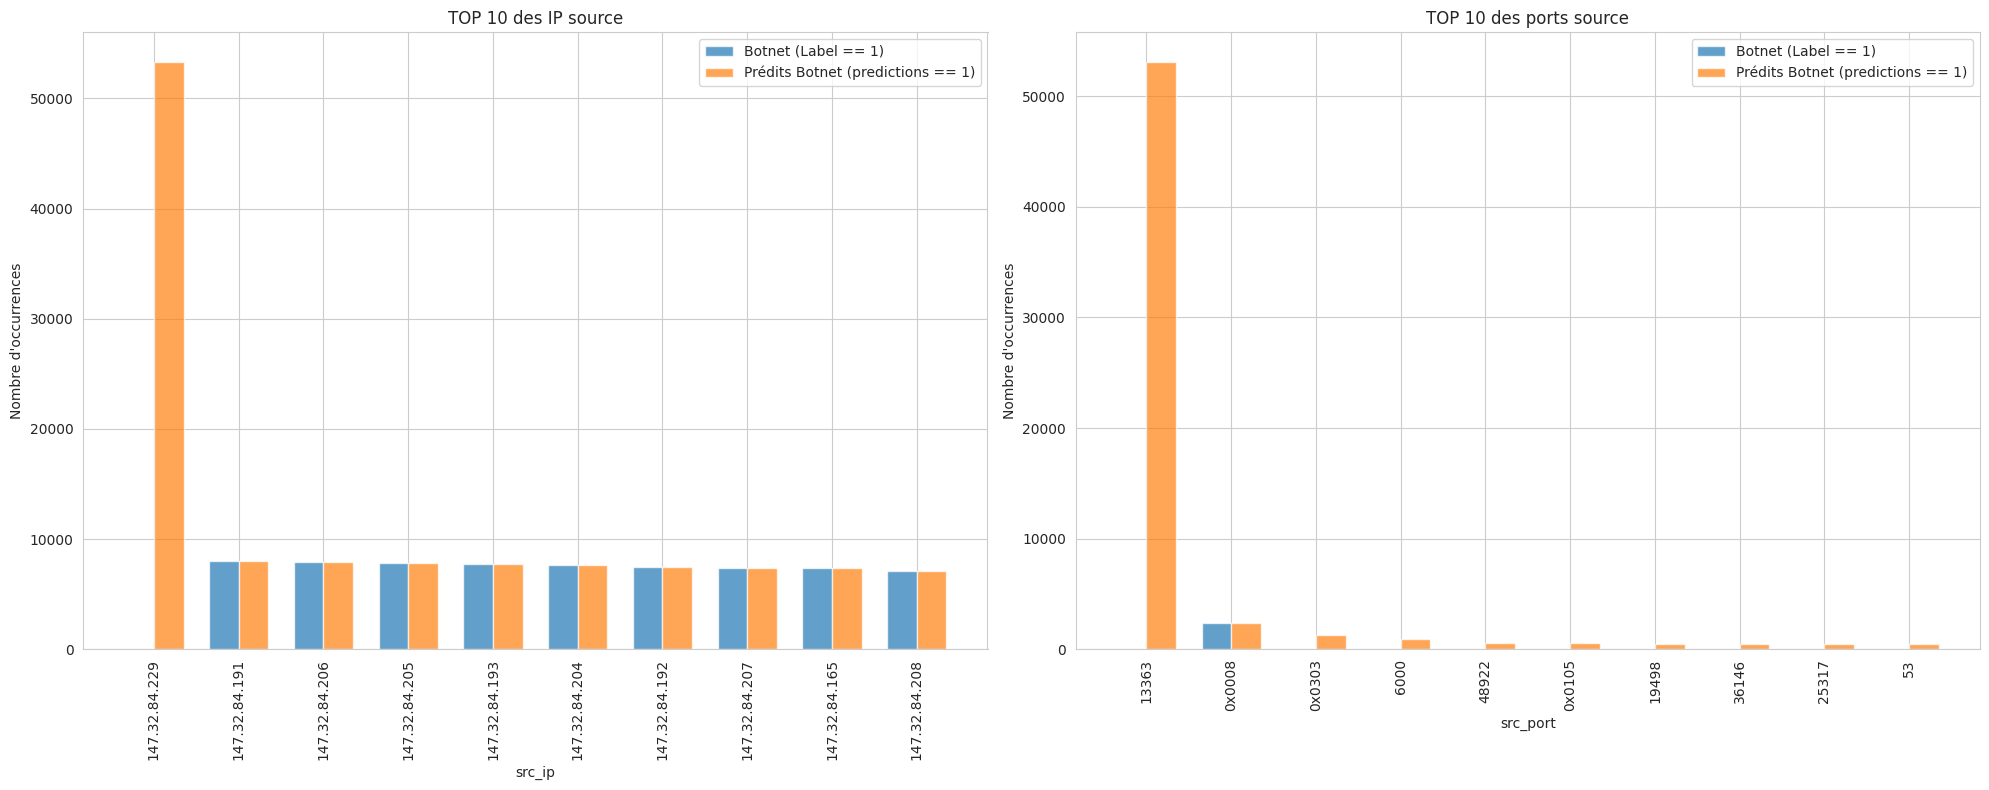

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Regroupement des données pour les IP source
botnet_ip_counts = df_processed[df_processed['Label'] == 1]['src_ip'].value_counts()
pred_ip_counts   = df_processed[df_processed['predictions'] == 1]['src_ip'].value_counts()

# Calcul des occurrences globales pour chaque IP et sélection du TOP 10
all_ip_counts = botnet_ip_counts.add(pred_ip_counts, fill_value=0)
top10_ips = all_ip_counts.sort_values(ascending=False).head(10).index.tolist()

# Préparation des valeurs pour les TOP 10 IP
botnet_ip_values = [botnet_ip_counts.get(ip, 0) for ip in top10_ips]
pred_ip_values   = [pred_ip_counts.get(ip, 0) for ip in top10_ips]

# Regroupement des données pour les ports source
botnet_port_counts = df_processed[df_processed['Label'] == 1]['src_port'].value_counts()
pred_port_counts   = df_processed[df_processed['predictions'] == 1]['src_port'].value_counts()

# Calcul des occurrences globales pour chaque port et sélection du TOP 10
all_port_counts = botnet_port_counts.add(pred_port_counts, fill_value=0)
top10_ports = all_port_counts.sort_values(ascending=False).head(10).index.tolist()

# Préparation des valeurs pour les TOP 10 ports
botnet_port_values = [botnet_port_counts.get(port, 0) for port in top10_ports]
pred_port_values   = [pred_port_counts.get(port, 0) for port in top10_ports]

# Paramètres d'affichage pour les barres groupées
width = 0.35

# Création d'une figure avec deux sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Graphique pour la distribution par IP source
x_ip = np.arange(len(top10_ips))
axs[0].bar(x_ip - width/2, botnet_ip_values, width, label='Botnet (Label == 1)', alpha=0.7)
axs[0].bar(x_ip + width/2, pred_ip_values, width, label='Prédits Botnet (predictions == 1)', alpha=0.7)
axs[0].set_xticks(x_ip)
axs[0].set_xticklabels(top10_ips, rotation=90)
axs[0].set_title("TOP 10 des IP source")
axs[0].set_xlabel("src_ip")
axs[0].set_ylabel("Nombre d'occurrences")
axs[0].legend()

# Graphique pour la distribution par port source
x_port = np.arange(len(top10_ports))
axs[1].bar(x_port - width/2, botnet_port_values, width, label='Botnet (Label == 1)', alpha=0.7)
axs[1].bar(x_port + width/2, pred_port_values, width, label='Prédits Botnet (predictions == 1)', alpha=0.7)
axs[1].set_xticks(x_port)
axs[1].set_xticklabels(top10_ports, rotation=90)
axs[1].set_title("TOP 10 des ports source")
axs[1].set_xlabel("src_port")
axs[1].set_ylabel("Nombre d'occurrences")
axs[1].legend()

plt.tight_layout()
plt.show()


#### **On remarque que la grande majorité des faux positifs proviennent de l'IP source 147.32.84.229 sur le port 13363**

### Nombre d'occurence en fonction des top 10 IP destination et des top 10 ports destination et

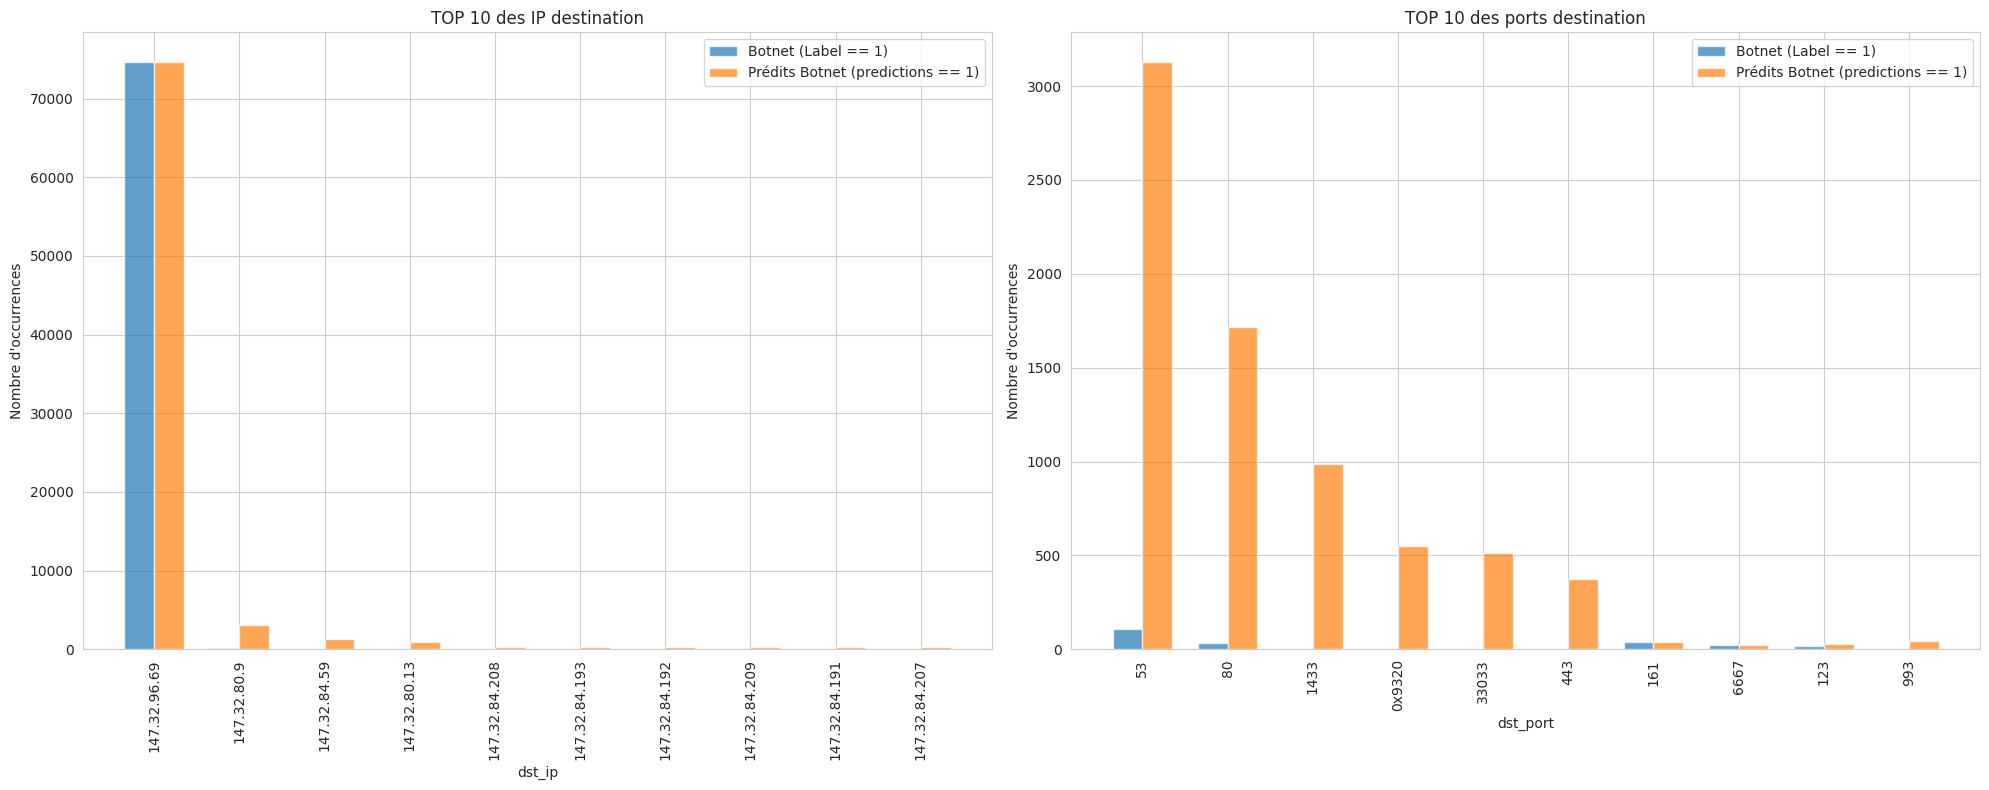

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Regroupement des données pour les IP source
botnet_ip_counts = df_processed[df_processed['Label'] == 1]['dst_ip'].value_counts()
pred_ip_counts   = df_processed[df_processed['predictions'] == 1]['dst_ip'].value_counts()

# Calcul des occurrences globales pour chaque IP et sélection du TOP 10
all_ip_counts = botnet_ip_counts.add(pred_ip_counts, fill_value=0)
top10_ips = all_ip_counts.sort_values(ascending=False).head(10).index.tolist()

# Préparation des valeurs pour les TOP 10 IP
botnet_ip_values = [botnet_ip_counts.get(ip, 0) for ip in top10_ips]
pred_ip_values   = [pred_ip_counts.get(ip, 0) for ip in top10_ips]

# Regroupement des données pour les ports source
botnet_port_counts = df_processed[df_processed['Label'] == 1]['dst_port'].value_counts()
pred_port_counts   = df_processed[df_processed['predictions'] == 1]['dst_port'].value_counts()

# Calcul des occurrences globales pour chaque port et sélection du TOP 10
all_port_counts = botnet_port_counts.add(pred_port_counts, fill_value=0)
top10_ports = all_port_counts.sort_values(ascending=False).head(10).index.tolist()

# Préparation des valeurs pour les TOP 10 ports
botnet_port_values = [botnet_port_counts.get(port, 0) for port in top10_ports]
pred_port_values   = [pred_port_counts.get(port, 0) for port in top10_ports]

# Paramètres d'affichage pour les barres groupées
width = 0.35

# Création d'une figure avec deux sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Graphique pour la distribution par IP source
x_ip = np.arange(len(top10_ips))
axs[0].bar(x_ip - width/2, botnet_ip_values, width, label='Botnet (Label == 1)', alpha=0.7)
axs[0].bar(x_ip + width/2, pred_ip_values, width, label='Prédits Botnet (predictions == 1)', alpha=0.7)
axs[0].set_xticks(x_ip)
axs[0].set_xticklabels(top10_ips, rotation=90)
axs[0].set_title("TOP 10 des IP destination")
axs[0].set_xlabel("dst_ip")
axs[0].set_ylabel("Nombre d'occurrences")
axs[0].legend()

# Graphique pour la distribution par port source
x_port = np.arange(len(top10_ports))
axs[1].bar(x_port - width/2, botnet_port_values, width, label='Botnet (Label == 1)', alpha=0.7)
axs[1].bar(x_port + width/2, pred_port_values, width, label='Prédits Botnet (predictions == 1)', alpha=0.7)
axs[1].set_xticks(x_port)
axs[1].set_xticklabels(top10_ports, rotation=90)
axs[1].set_title("TOP 10 des ports destination")
axs[1].set_xlabel("dst_port")
axs[1].set_ylabel("Nombre d'occurrences")
axs[1].legend()

plt.tight_layout()
plt.show()


#### **On remarque les ports utilisés par les botnets sont très diverses. Ils possèdent donc bien une grande variance au niveau des ports de destination**

### Histogramme du nombre d'occurence des botnets et prédits en fonction du nombre total de packets

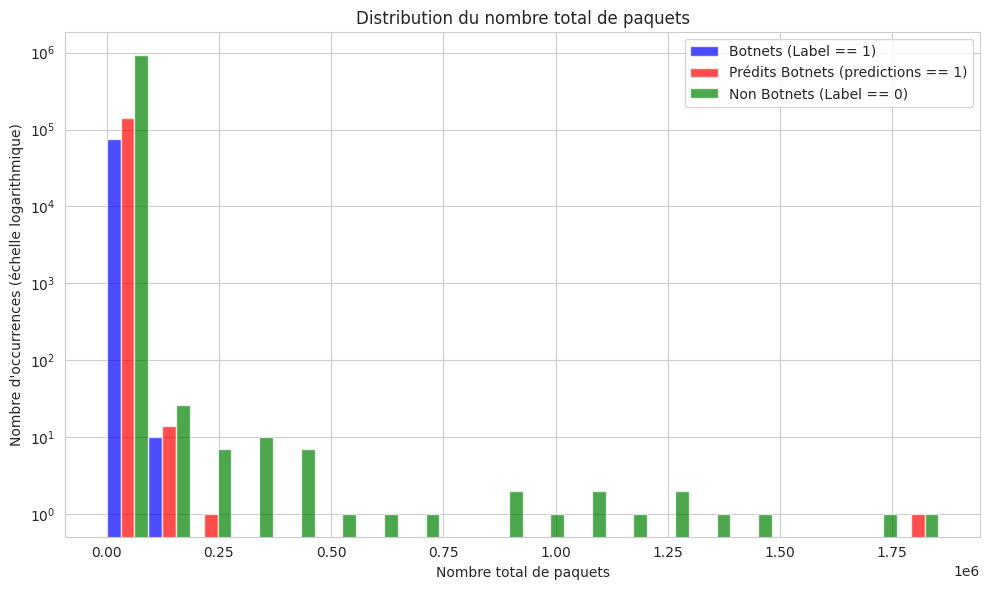

In [22]:
# Nombre de bins réduit pour une vue compacte
nbins = 20

# Extraction des données depuis df_processed
botnet_total_packets     = df_processed[df_processed['Label'] == 1]['total_packets']
pred_total_packets       = df_processed[df_processed['predictions'] == 1]['total_packets']
non_botnet_total_packets = df_processed[df_processed['Label'] == 0]['total_packets']

# Détermination des bornes communes pour les bins
min_val = min(botnet_total_packets.min(), pred_total_packets.min(), non_botnet_total_packets.min())
max_val = max(botnet_total_packets.max(), pred_total_packets.max(), non_botnet_total_packets.max())

# Création des bins
bins = np.linspace(min_val, max_val, nbins + 1)

# Calcul des fréquences pour chaque groupe
botnet_counts, _     = np.histogram(botnet_total_packets, bins=bins)
pred_counts, _       = np.histogram(pred_total_packets, bins=bins)
non_botnet_counts, _ = np.histogram(non_botnet_total_packets, bins=bins)

# Calcul des centres de bins
bin_centers = (bins[:-1] + bins[1:]) / 2
# Largeur d'une barre : un tiers de la largeur du bin
bar_width = (bins[1] - bins[0]) / 3

plt.figure(figsize=(10, 6))
plt.bar(bin_centers - bar_width, botnet_counts, width=bar_width, label='Botnets (Label == 1)', color='blue', alpha=0.7)
plt.bar(bin_centers,           pred_counts,   width=bar_width, label='Prédits Botnets (predictions == 1)', color='red', alpha=0.7)
plt.bar(bin_centers + bar_width, non_botnet_counts, width=bar_width, label='Non Botnets (Label == 0)', color='green', alpha=0.7)
plt.xlabel("Nombre total de paquets")
plt.ylabel("Nombre d'occurrences (échelle logarithmique)")
plt.yscale("log")
plt.title("Distribution du nombre total de paquets")
plt.legend()
plt.tight_layout()
plt.show()



### Histogramme du nombre d'occurence des botnets et prédits en fonction du nombre total de bytes

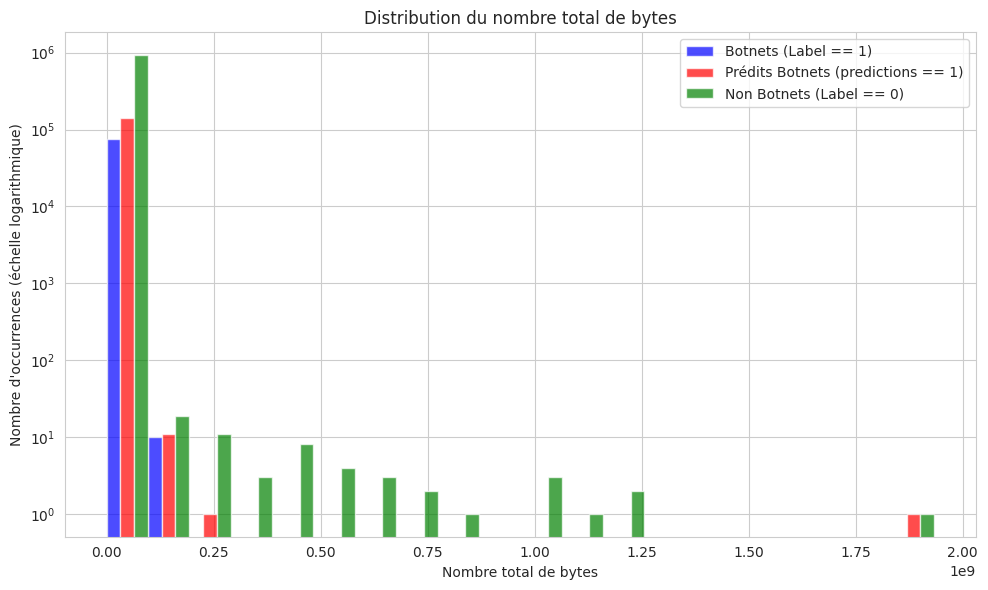

In [23]:
nbins = 20

botnet_total_bytes     = df_processed[df_processed['Label'] == 1]['total_bytes']
pred_total_bytes       = df_processed[df_processed['predictions'] == 1]['total_bytes']
non_botnet_total_bytes = df_processed[df_processed['Label'] == 0]['total_bytes']

min_val = min(botnet_total_bytes.min(), pred_total_bytes.min(), non_botnet_total_bytes.min())
max_val = max(botnet_total_bytes.max(), pred_total_bytes.max(), non_botnet_total_bytes.max())

bins = np.linspace(min_val, max_val, nbins + 1)

botnet_counts, _     = np.histogram(botnet_total_bytes, bins=bins)
pred_counts, _       = np.histogram(pred_total_bytes, bins=bins)
non_botnet_counts, _ = np.histogram(non_botnet_total_bytes, bins=bins)

bin_centers = (bins[:-1] + bins[1:]) / 2
bar_width = (bins[1] - bins[0]) / 3

plt.figure(figsize=(10, 6))
plt.bar(bin_centers - bar_width, botnet_counts, width=bar_width, label='Botnets (Label == 1)', color='blue', alpha=0.7)
plt.bar(bin_centers,           pred_counts,   width=bar_width, label='Prédits Botnets (predictions == 1)', color='red', alpha=0.7)
plt.bar(bin_centers + bar_width, non_botnet_counts, width=bar_width, label='Non Botnets (Label == 0)', color='green', alpha=0.7)
plt.xlabel("Nombre total de bytes")
plt.ylabel("Nombre d'occurrences (échelle logarithmique)")
plt.yscale("log")
plt.title("Distribution du nombre total de bytes")
plt.legend()
plt.tight_layout()
plt.show()


### Histogramme du nombre de src_bytes

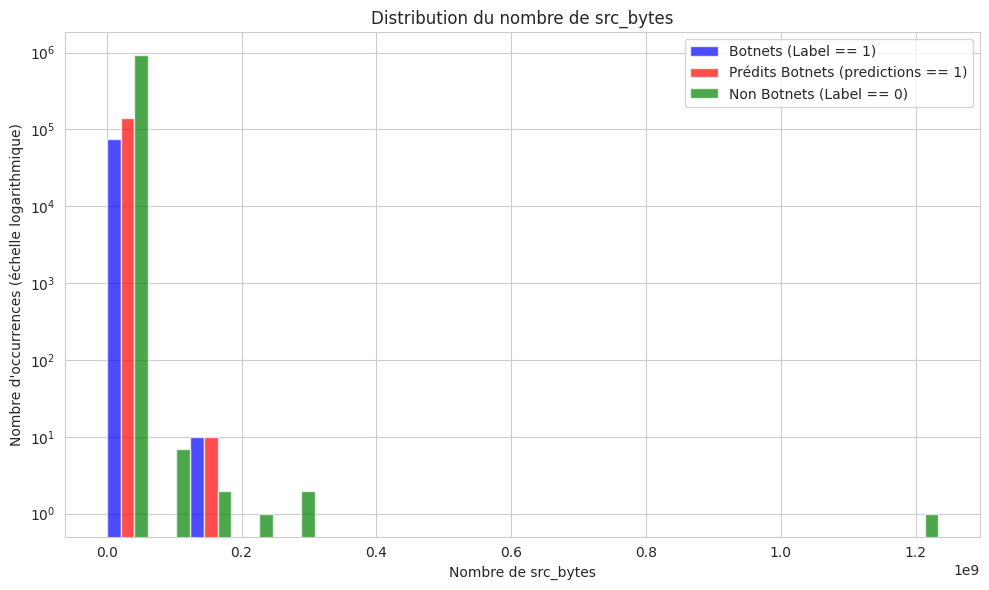

In [24]:
nbins = 20

botnet_src_bytes     = df_processed[df_processed['Label'] == 1]['src_bytes']
pred_src_bytes       = df_processed[df_processed['predictions'] == 1]['src_bytes']
non_botnet_src_bytes = df_processed[df_processed['Label'] == 0]['src_bytes']

min_val = min(botnet_src_bytes.min(), pred_src_bytes.min(), non_botnet_src_bytes.min())
max_val = max(botnet_src_bytes.max(), pred_src_bytes.max(), non_botnet_src_bytes.max())

bins = np.linspace(min_val, max_val, nbins + 1)

botnet_counts, _     = np.histogram(botnet_src_bytes, bins=bins)
pred_counts, _       = np.histogram(pred_src_bytes, bins=bins)
non_botnet_counts, _ = np.histogram(non_botnet_src_bytes, bins=bins)

bin_centers = (bins[:-1] + bins[1:]) / 2
bar_width = (bins[1] - bins[0]) / 3

plt.figure(figsize=(10, 6))
plt.bar(bin_centers - bar_width, botnet_counts, width=bar_width, label='Botnets (Label == 1)', color='blue', alpha=0.7)
plt.bar(bin_centers,           pred_counts,   width=bar_width, label='Prédits Botnets (predictions == 1)', color='red', alpha=0.7)
plt.bar(bin_centers + bar_width, non_botnet_counts, width=bar_width, label='Non Botnets (Label == 0)', color='green', alpha=0.7)
plt.xlabel("Nombre de src_bytes")
plt.ylabel("Nombre d'occurrences (échelle logarithmique)")
plt.yscale("log")
plt.title("Distribution du nombre de src_bytes")
plt.legend()
plt.tight_layout()
plt.show()


### Distribution des protocoles (Bar Chart)

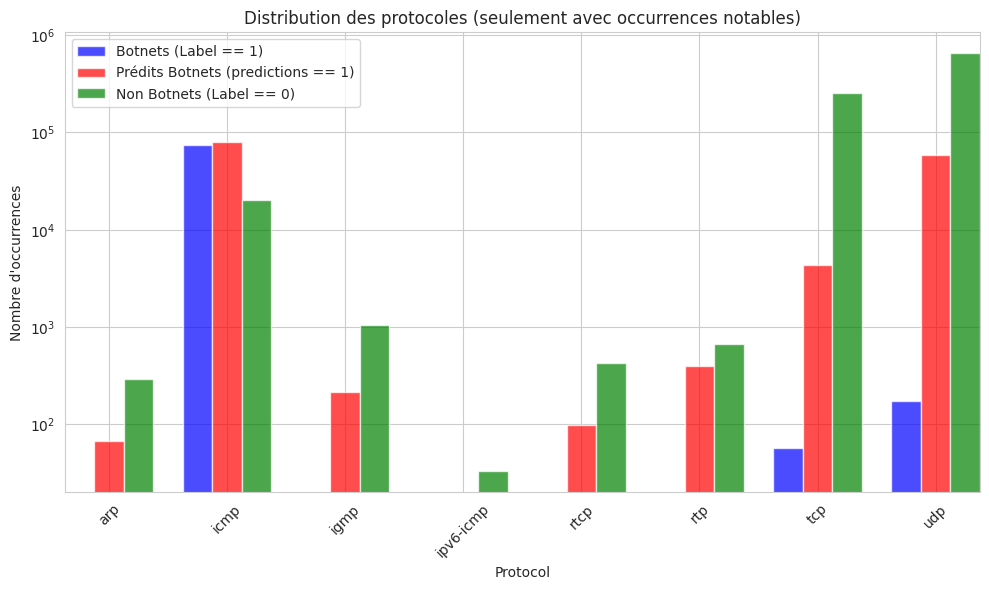

In [25]:
# Seuil minimal d'occurrences pour afficher un protocole
threshold = 10

# Extraction des fréquences pour chaque protocole
botnet_protocol_counts      = df_processed[df_processed['Label'] == 1]['protocol'].value_counts()
pred_protocol_counts        = df_processed[df_processed['predictions'] == 1]['protocol'].value_counts()
non_botnet_protocol_counts  = df_processed[df_processed['Label'] == 0]['protocol'].value_counts()

# Calcul du nombre total d'occurrences par protocole
total_protocol_counts = botnet_protocol_counts.add(pred_protocol_counts, fill_value=0)\
                                              .add(non_botnet_protocol_counts, fill_value=0)

# Filtrage des protocoles ayant au moins 'threshold' occurrences
protocols_filtered = total_protocol_counts[total_protocol_counts >= threshold].index
protocols = sorted(protocols_filtered)

botnet_protocol_values      = [botnet_protocol_counts.get(proto, 0) for proto in protocols]
pred_protocol_values        = [pred_protocol_counts.get(proto, 0) for proto in protocols]
non_botnet_protocol_values  = [non_botnet_protocol_counts.get(proto, 0) for proto in protocols]

x = np.arange(len(protocols))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, botnet_protocol_values, width, label='Botnets (Label == 1)', color='blue', alpha=0.7)
plt.bar(x, pred_protocol_values, width, label='Prédits Botnets (predictions == 1)', color='red', alpha=0.7)
plt.bar(x + width, non_botnet_protocol_values, width, label='Non Botnets (Label == 0)', color='green', alpha=0.7)
plt.xticks(x, protocols, rotation=45)
plt.xlabel("Protocol")
plt.ylabel("Nombre d'occurrences")
plt.title("Distribution des protocoles (seulement avec occurrences notables)")
plt.xlim(-width*1.5, len(protocols)-1+width*1.5)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()
